In [12]:
import os
import numpy as np
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import random
import os

In [2]:
IMAGE_DIR = 'data/images'
MASK_DIR = 'data/masks'
BATCH_SIZE = 4
LR = 1e-4

IMG_SIZE = (128,128)  # resize input

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class EyeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        # Ground truth mask
        gt_path = self.mask_paths[idx]
        gt = Image.open(gt_path).convert("L")

        # Apply transformations if any
        if self.transform:
            img_tensor = self.transform(img)
            gt_tensor = self.transform(gt)
        else:
            img_tensor = transforms.ToTensor()(img)
            gt_tensor = transforms.ToTensor()(gt)

        # Binarize the mask if necessary
        gt_tensor = (gt_tensor > 0.5).float()


        return img_tensor, gt_tensor

In [5]:
image_paths = sorted(glob(os.path.join(IMAGE_DIR, '*')))
mask_paths = sorted(glob(os.path.join(MASK_DIR, '*')))

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE)
])

train_dataset = EyeDataset(train_imgs, train_masks, transform=transform)
val_dataset = EyeDataset(val_imgs, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:


model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)


In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, ignore_index=255, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.CE_loss = nn.CrossEntropyLoss(
            reduction=reduction, ignore_index=ignore_index, weight=alpha)

    def forward(self, output, target):
        logpt = self.CE_loss(output, target)
        pt = torch.exp(-logpt)
        loss = ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()


class BCELoss(nn.Module):
    def __init__(self, reduction="mean", pos_weight=1.0):
        pos_weight = torch.tensor(pos_weight).cuda()
        super(BCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(
            reduction=reduction, pos_weight=pos_weight)

    def forward(self, prediction, targets):
        return self.bce_loss(prediction, targets)


class CELoss(nn.Module):
    def __init__(self, weight=[1, 1], ignore_index=-100, reduction='mean'):
        super(CELoss, self).__init__()
        weight = torch.tensor(weight).cuda()
        self.CE = nn.CrossEntropyLoss(
            weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target.squeeze(1).long())
        return loss


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, prediction, target):
        prediction = torch.sigmoid(prediction)
        intersection = 2 * torch.sum(prediction * target) + self.smooth
        union = torch.sum(prediction) + torch.sum(target) + self.smooth
        loss = 1 - intersection / union
        return loss


class CE_DiceLoss(nn.Module):
    def __init__(self, reduction="mean", D_weight=0.5):
        super(CE_DiceLoss, self).__init__()
        self.DiceLoss = DiceLoss()
        self.BCELoss = BCELoss(reduction=reduction)
        self.D_weight = D_weight

    def forward(self, prediction, targets):
        return self.D_weight * self.DiceLoss(prediction, targets) + (1 - self.D_weight) * self.BCELoss(prediction,
                                                                                                       targets)


In [8]:
combo_loss = CE_DiceLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [9]:
from torch.nn.utils import clip_grad_norm_


def train(model, loader):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc='Training', leave=False)
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = combo_loss(preds, masks)
        optimizer.zero_grad()

        clip_grad_norm_(model.parameters(), 1.0)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    loop = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = combo_loss(preds, masks)
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)

In [10]:
EPOCHS = 100

In [14]:
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_attention_vein_model2.pth')
    #0.35 loss DeepV3
    # Save every 5 epochs   
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"checkpoint2_epoch_{epoch+1}.pth")


Epoch 1/100


KeyboardInterrupt: 

Images saved: visualization_images\input_183.png, visualization_images\mask_183.png, visualization_images\pred_183.png


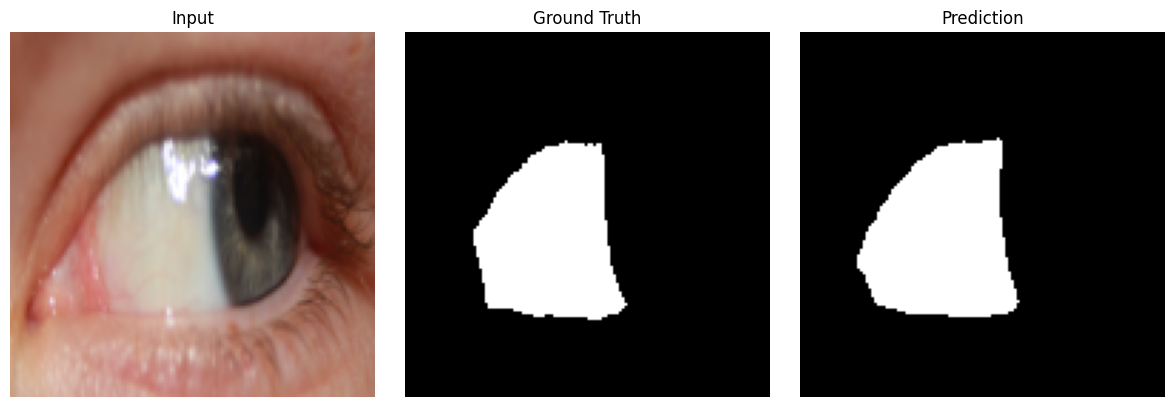

In [16]:

model.load_state_dict(torch.load('checkpoint2_epoch_5.pth'))  # or the latest checkpoint
model.to(device)  # Send to GPU if needed

def visualize_sample(model, dataset, device='cpu', save_dir='visualization_images'):
    model.eval()
    
    # Randomly select an index
    idx = random.randint(0, len(dataset) - 1)
    
    img, mask = dataset[idx]
    
    # Ensure the image is on the right device and process it correctly
    with torch.no_grad():
        # Move the image tensor to the same device as the model
        img = img.to(device)
        pred = model(img.unsqueeze(0).to(device))[0][0].cpu().sigmoid().numpy()  # Get prediction

    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Show the RGB input image (move the image to CPU and convert to numpy)
    ax[0].imshow(img.permute(1, 2, 0).cpu().numpy())  # Convert (3, H, W) to (H, W, 3) for RGB image
    ax[0].set_title('Input')
    ax[0].axis('off')  # Hide axes for a cleaner display

    # Show the grayscale mask
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')
    ax[1].axis('off')

    # Show the predicted mask (binary thresholded)
    ax[2].imshow(pred > 0.4, cmap='gray')
    ax[2].set_title('Prediction')
    ax[2].axis('off')

    plt.tight_layout()

    # Save the images separately
    input_save_path = os.path.join(save_dir, f'input_{idx}.png')
    mask_save_path = os.path.join(save_dir, f'mask_{idx}.png')
    pred_save_path = os.path.join(save_dir, f'pred_{idx}.png')

    # Save each of the individual images
    plt.figure(figsize=(6, 6))
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())  # Convert (3, H, W) to (H, W, 3) for RGB image
    plt.axis('off')
    plt.savefig(input_save_path)
    plt.close()

    plt.figure(figsize=(6, 6))
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig(mask_save_path)
    plt.close()

    plt.figure(figsize=(6, 6))
    plt.imshow(pred > 0.5, cmap='gray')
    plt.axis('off')
    plt.savefig(pred_save_path)
    plt.close()

    print(f"Images saved: {input_save_path}, {mask_save_path}, {pred_save_path}")

    # Display the images together
    plt.show()

# Optional: visualize after training
visualize_sample(model, val_dataset, device='cuda')  # Example if using GPU



# visualize_sample(model, val_dataset, device='cuda') 
